# Initial Steps

In [17]:
# Install required libraries
!pip install polars scikit-learn imbalanced-learn interpret --quiet

In [18]:
# Imports
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [19]:
# Load the full dataset using Polars
df = pl.read_csv("/content/cleaned_train.csv")

In [20]:
# Drop unnecessary columns and convert to pandas
df = df.drop(["Customer_ID", "outlet_city"])
X = df.drop("cluster_category").to_pandas()
y = df["cluster_category"].to_pandas().astype(int)

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
# Balance classes using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# EBM (Train Accuracy: 0.8453, Test Accuracy: 0.8442)

In [23]:
param_grid = {
    "max_rounds": [10, 20],
    "max_leaves": [3, 5],
    "learning_rate": [0.005, 0.01],
    "early_stopping_rounds": [5, 10]
}

In [24]:
from sklearn.model_selection import StratifiedKFold
ebm = ExplainableBoostingClassifier(interactions=0, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(ebm, param_grid, n_iter=5, cv=cv, scoring='f1_macro', n_jobs=-1)
search.fit(X_train, y_train)
best_ebm_model = search.best_estimator_

In [25]:
best_ebm_model

ExplainableBoostingClassifier(early_stopping_rounds=5, interactions=0,
                              learning_rate=0.01, max_leaves=5, max_rounds=20)

In [26]:
# Predictions
y_pred = best_ebm_model.predict(X_test)
# Metrics
print(f"Train Acc: {accuracy_score(y_train, best_ebm_model.predict(X_train)):.4f}")
print(f"Test Acc: {accuracy_score(y_test, y_pred):.4f}")

Train Acc: 0.8453
Test Acc: 0.8442



Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.66      0.75     34054
           2       0.94      0.89      0.91     31142
           3       0.77      0.81      0.79      9639
           4       0.74      0.87      0.80     28436
           5       0.57      0.86      0.69      5360
           6       0.93      0.97      0.95     33892

    accuracy                           0.84    142523
   macro avg       0.80      0.84      0.82    142523
weighted avg       0.86      0.84      0.84    142523



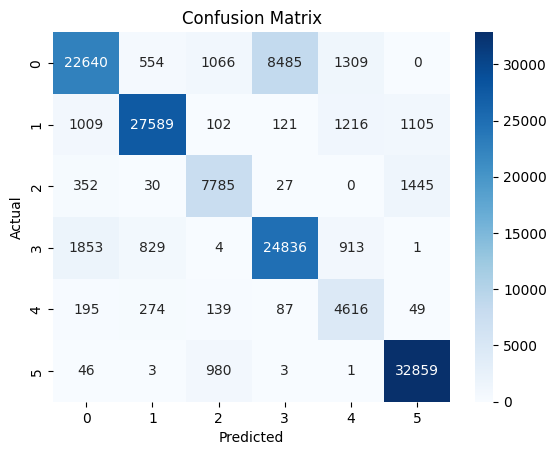

In [27]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

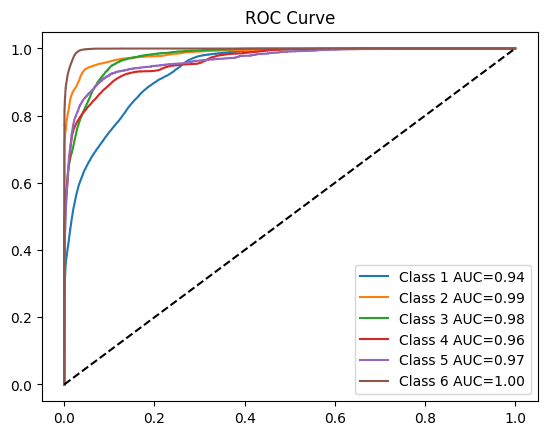

In [28]:
# ROC Curve
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6])
probs = best_ebm_model.predict_proba(X_test)
for i in range(6):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} AUC={roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.legend()
plt.show()

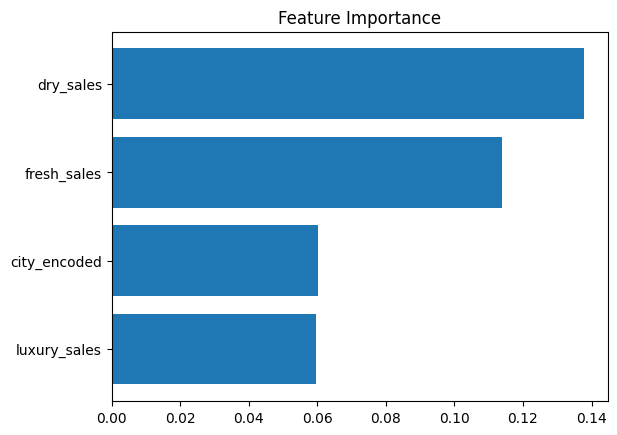

In [29]:
# Feature Importance
expl = best_ebm_model.explain_global()
feat_df = pd.DataFrame({
    'Feature': expl.data()['names'],
    'Importance': expl.data()['scores']
}).sort_values(by='Importance', ascending=False)
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

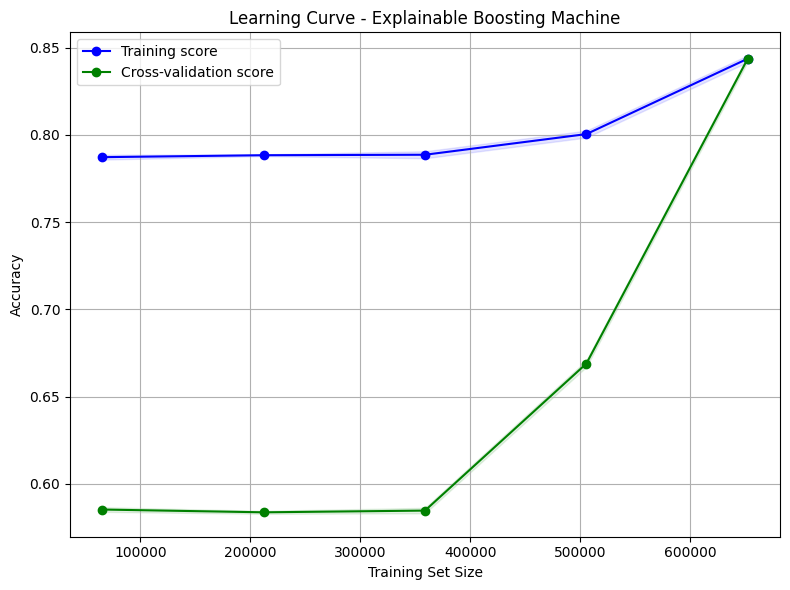

In [30]:
from sklearn.model_selection import learning_curve

# Define training sizes for learning curve (e.g., 10%, 30%, 50%, 70%, 100%)
train_sizes = np.linspace(0.1, 1.0, 5)

# Calculate learning curve (using the best EBM model and stratified splits)
train_sizes, train_scores, test_scores = learning_curve(
    best_ebm_model, X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    train_sizes=train_sizes,
    n_jobs=-1
)

# Calculate mean and std dev for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.title('Learning Curve - Explainable Boosting Machine')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest (Train Accuracy: 0.9981, Test Accuracy: 0.9982)

In [21]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize

In [22]:
# Convert inputs to Polars once
X_train_pl = pl.from_pandas(X_train) if not isinstance(X_train, pl.DataFrame) else X_train
X_test_pl = pl.from_pandas(X_test) if not isinstance(X_test, pl.DataFrame) else X_test
y_train_pl = pl.Series("cluster_category", y_train) if not isinstance(y_train, pl.Series) else y_train
y_test_pl = pl.Series("cluster_category", y_test) if not isinstance(y_test, pl.Series) else y_test

# Convert Polars to NumPy once
X_train_np = X_train_pl.to_numpy()
X_test_np = X_test_pl.to_numpy()
y_train_np = y_train_pl.to_numpy().ravel()
y_test_np = y_test_pl.to_numpy().ravel()

In [23]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Optimized param grid - fewer trees, higher min_samples_leaf
param_grid = {
    "n_estimators": [50],            # half the trees for speed
    "max_depth": [10, 15],           # keep reasonable depth
    "min_samples_split": [5, 10],    # increase splits to reduce tree growth
    "min_samples_leaf": [2, 3],      # leaf size up to reduce overfitting & speed
    "max_features": ['sqrt'],
    "bootstrap": [True]
}

In [24]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    rf_model,
    param_grid,
    n_iter=5,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("🔹 Training Random Forest with optimized parameters...\n")
random_search.fit(X_train_np, y_train_np)

best_rf_model = random_search.best_estimator_
best_rf_model

🔹 Training Random Forest with optimized parameters...

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomForestClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [25]:
# Predictions
y_train_pred = best_rf_model.predict(X_train_np)
y_test_pred = best_rf_model.predict(X_test_np)

print(f"\n✅ Best Parameters: {random_search.best_params_}")
print(f"\n🔹 Random Forest Accuracy:")
print(f"   Train Accuracy: {accuracy_score(y_train_np, y_train_pred):.4f}")
print(f"   Test Accuracy: {accuracy_score(y_test_np, y_test_pred):.4f}")

print("\n🔹 Classification Report:")
print(classification_report(y_test_np, y_test_pred))


✅ Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}

🔹 Random Forest Accuracy:
   Train Accuracy: 0.9981
   Test Accuracy: 0.9982

🔹 Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     34054
           2       1.00      1.00      1.00     31142
           3       0.99      1.00      0.99      9639
           4       1.00      1.00      1.00     28436
           5       0.99      0.99      0.99      5360
           6       1.00      1.00      1.00     33892

    accuracy                           1.00    142523
   macro avg       1.00      1.00      1.00    142523
weighted avg       1.00      1.00      1.00    142523



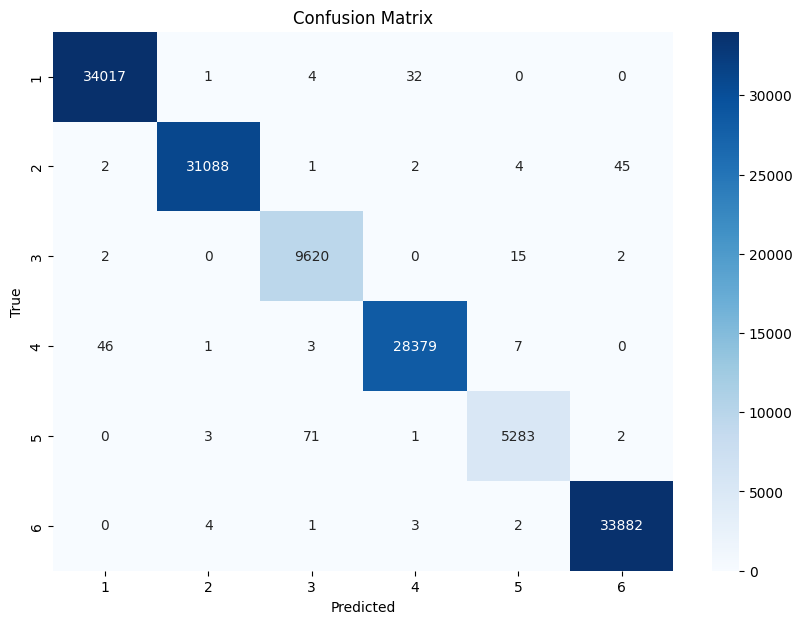

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test_np, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_np), yticklabels=np.unique(y_test_np))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


🔹 ROC-AUC Score (macro): 0.9999


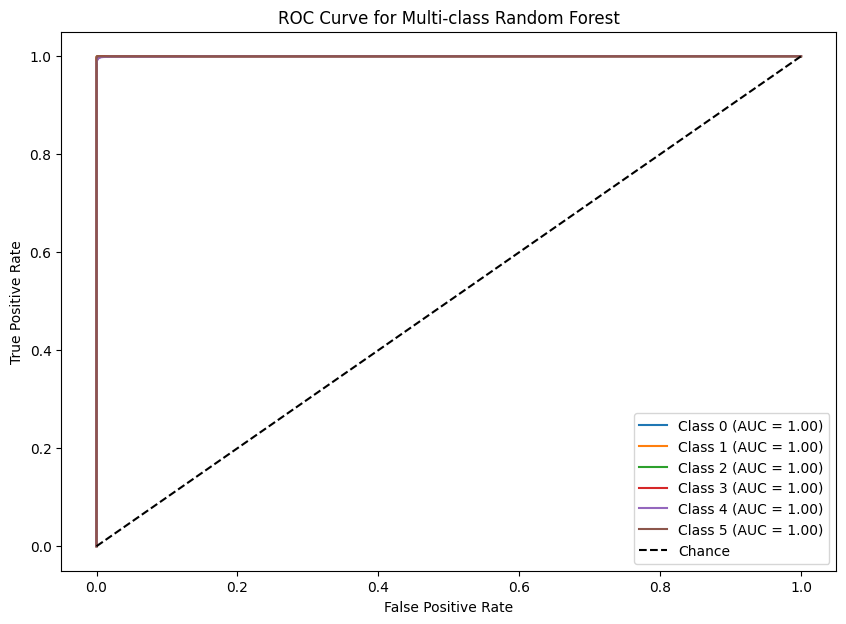

In [27]:
# ROC-AUC (macro)
roc_auc = roc_auc_score(y_test_np, best_rf_model.predict_proba(X_test_np), multi_class='ovr')
print(f"\n🔹 ROC-AUC Score (macro): {roc_auc:.4f}")

# Multi-class ROC Curve
y_test_bin = label_binarize(y_test_np, classes=np.unique(y_test_np))
fpr, tpr, roc_auc_class = {}, {}, {}

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], best_rf_model.predict_proba(X_test_np)[:, i])
    roc_auc_class[i] = roc_auc_score(y_test_bin[:, i], best_rf_model.predict_proba(X_test_np)[:, i])

plt.figure(figsize=(10, 7))
for i in range(len(np.unique(y_test_np))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc_class[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Random Forest')
plt.legend(loc='best')
plt.show()

<ipython-input-29-7d6fd066e43d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette='viridis')


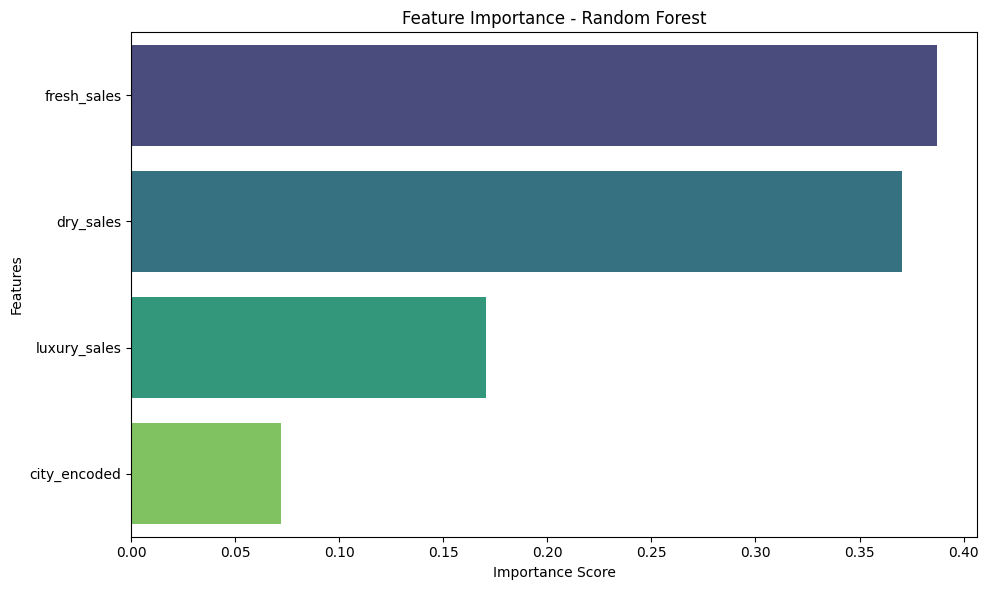

In [29]:
# Feature Importances
importances = best_rf_model.feature_importances_
features = np.array(X_train_pl.columns)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


# XGBoost (Train Accuracy: 0.9999, Test Accuracy: 0.9997)

In [30]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split, learning_curve
from sklearn.preprocessing import label_binarize

In [31]:
# Assume X and y are Polars DataFrame and Series respectively
# Adjust class labels to start from 0
y_adjusted = (y - 1).to_numpy().ravel()   # Shift [1,2,3,4,5,6] → [0,1,2,3,4,5]
X_np = X.to_numpy()

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_adjusted, test_size=0.2, random_state=42
)

In [32]:
# Define XGBoost model
xgb_model = XGBClassifier(eval_metric='mlogloss')

# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0]
}

In [33]:
# Randomized Search
print(f"\n🔹 Training XGBoost with Randomized Search...\n")
random_search = RandomizedSearchCV(
    xgb_model,
    param_grid,
    cv=2,
    scoring='f1_macro',
    n_jobs=-1,
    n_iter=10,
    random_state=42
)
random_search.fit(X_train, y_train)
best_xgb_model = random_search.best_estimator_

print(f"✅ Best Parameters for XGBoost: {random_search.best_params_}\n")


🔹 Training XGBoost with Randomized Search...

✅ Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2}



In [34]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

# Accuracy
train_acc_xgb = accuracy_score(y_train, y_train_pred)
test_acc_xgb = accuracy_score(y_test, y_test_pred)

print(f"🔹 XGBoost Accuracy:")
print(f"   Train Accuracy: {train_acc_xgb:.4f}")
print(f"   Test Accuracy: {test_acc_xgb:.4f}")
if train_acc_xgb - test_acc_xgb > 0.1:
    print(f"⚠️ Warning: XGBoost may be overfitting!\n")

🔹 XGBoost Accuracy:
   Train Accuracy: 0.9999
   Test Accuracy: 0.9997


In [35]:
# Classification Report
print(f"\n🔹 Classification Report for XGBoost:\n")
print(classification_report(y_test, y_test_pred))


🔹 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34054
           1       1.00      1.00      1.00     31142
           2       1.00      1.00      1.00      9639
           3       1.00      1.00      1.00     28436
           4       1.00      1.00      1.00      5360
           5       1.00      1.00      1.00     33892

    accuracy                           1.00    142523
   macro avg       1.00      1.00      1.00    142523
weighted avg       1.00      1.00      1.00    142523



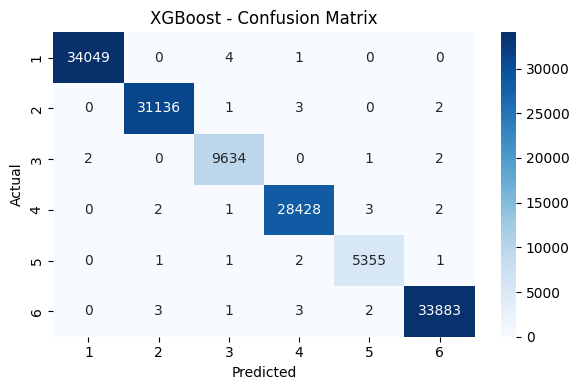

In [36]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=range(1,7), yticklabels=range(1,7))
plt.title(f"XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

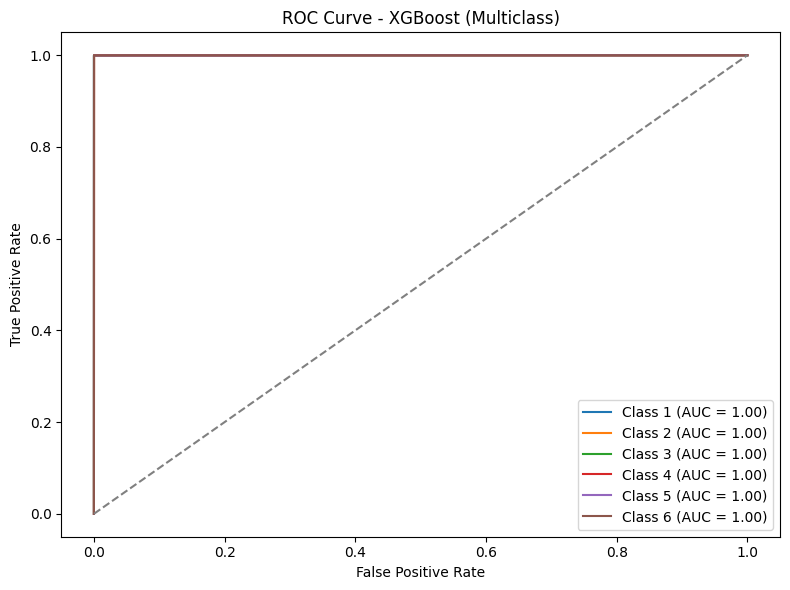

In [37]:
# ROC Curve
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
y_test_pred_proba = best_xgb_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], y_test_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - XGBoost (Multiclass)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

<ipython-input-38-b78002c4c7d5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='viridis')


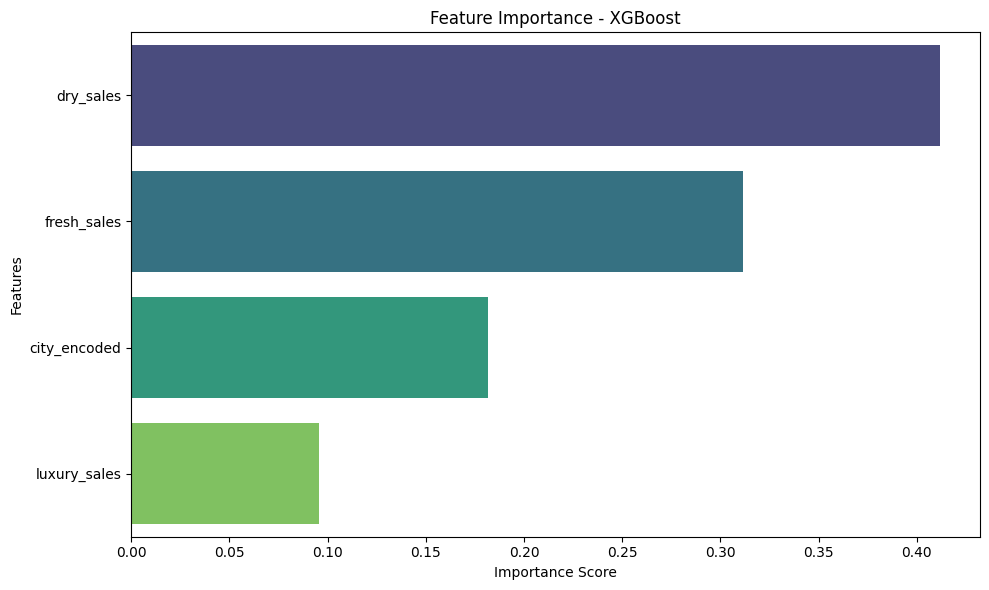

In [38]:
# Feature Importances
importances = best_xgb_model.feature_importances_
features = X.columns  # Polars column names
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='viridis')
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# LightGBM (Train Accuracy: 0.9997, Test Accuracy: 0.9995)

In [39]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from lightgbm import LGBMClassifier

In [42]:
# Hyperparameter tuning
param_grid = {
    "n_estimators": [100, 150],
    "num_leaves": [31, 50],
    "learning_rate": [0.05, 0.1]
}

random_search = RandomizedSearchCV(
    LGBMClassifier(n_jobs=-1),
    param_distributions=param_grid,
    cv=2,
    n_iter=5,
    scoring='f1_macro',
    random_state=42
)

random_search.fit(X_train, y_train)
best_lgbm_model = random_search.best_estimator_

# Train the model
best_lgbm_model.fit(
    X_train, y_train,
    eval_metric='multi_logloss',
)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 285045, number of used features: 4
[LightGBM] [Info] Start training from score -1.433595
[LightGBM] [Info] Start training from score -1.526174
[LightGBM] [Info] Start training from score -2.675537
[LightGBM] [Info] Start training from score -1.608772
[LightGBM] [Info] Start training from score -3.274862
[LightGBM] [Info] Start training from score -1.438181


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 285046, number of used features: 4
[LightGBM] [Info] Start training from score -1.433599
[LightGBM] [Info] Start training from score -1.526178
[LightGBM] [Info] Start training from score -2.675541
[LightGBM] [Info] Start training from score -1.608775
[LightGBM] [Info] Start training from score -3.274865
[LightGBM] [Info] Start training from score -1.438170


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 285045, number of used features: 4
[LightGBM] [Info] Start training from score -1.433595
[LightGBM] [Info] Start training from score -1.526174
[LightGBM] [Info] Start training from score -2.675537
[LightGBM] [Info] Start training from score -1.608772
[LightGBM] [Info] Start training from score -3.274862
[LightGBM] [Info] Start training from score -1.438181


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 285046, number of used features: 4
[LightGBM] [Info] Start training from score -1.433599
[LightGBM] [Info] Start training from score -1.526178
[LightGBM] [Info] Start training from score -2.675541
[LightGBM] [Info] Start training from score -1.608775
[LightGBM] [Info] Start training from score -3.274865
[LightGBM] [Info] Start training from score -1.438170


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 285045, number of used features: 4
[LightGBM] [Info] Start training from score -1.433595
[LightGBM] [Info] Start training from score -1.526174
[LightGBM] [Info] Start training from score -2.675537
[LightGBM] [Info] Start training from score -1.608772
[LightGBM] [Info] Start training from score -3.274862
[LightGBM] [Info] Start training from score -1.438181


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 285046, number of used features: 4
[LightGBM] [Info] Start training from score -1.433599
[LightGBM] [Info] Start training from score -1.526178
[LightGBM] [Info] Start training from score -2.675541
[LightGBM] [Info] Start training from score -1.608775
[LightGBM] [Info] Start training from score -3.274865
[LightGBM] [Info] Start training from score -1.438170


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 285045, number of used features: 4
[LightGBM] [Info] Start training from score -1.433595
[LightGBM] [Info] Start training from score -1.526174
[LightGBM] [Info] Start training from score -2.675537
[LightGBM] [Info] Start training from score -1.608772
[LightGBM] [Info] Start training from score -3.274862
[LightGBM] [Info] Start training from score -1.438181


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 285046, number of used features: 4
[LightGBM] [Info] Start training from score -1.433599
[LightGBM] [Info] Start training from score -1.526178
[LightGBM] [Info] Start training from score -2.675541
[LightGBM] [Info] Start training from score -1.608775
[LightGBM] [Info] Start training from score -3.274865
[LightGBM] [Info] Start training from score -1.438170


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 285045, number of used features: 4
[LightGBM] [Info] Start training from score -1.433595
[LightGBM] [Info] Start training from score -1.526174
[LightGBM] [Info] Start training from score -2.675537
[LightGBM] [Info] Start training from score -1.608772
[LightGBM] [Info] Start training from score -3.274862
[LightGBM] [Info] Start training from score -1.438181


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 285046, number of used features: 4
[LightGBM] [Info] Start training from score -1.433599
[LightGBM] [Info] Start training from score -1.526178
[LightGBM] [Info] Start training from score -2.675541
[LightGBM] [Info] Start training from score -1.608775
[LightGBM] [Info] Start training from score -3.274865
[LightGBM] [Info] Start training from score -1.438170


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 570091, number of used features: 4
[LightGBM] [Info] Start training from score -1.433597
[LightGBM] [Info] Start training from score -1.526176
[LightGBM] [Info] Start training from score -2.675539
[LightGBM] [Info] Start training from score -1.608773
[LightGBM] [Info] Start training from score -3.274863
[LightGBM] [Info] Start training from score -1.438176


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 570091, number of used features: 4
[LightGBM] [Info] Start training from score -1.433597
[LightGBM] [Info] Start training from score -1.526176
[LightGBM] [Info] Start training from score -2.675539
[LightGBM] [Info] Start training from score -1.608773
[LightGBM] [Info] Start training from score -3.274863
[LightGBM] [Info] Start training from score -1.438176


LGBMClassifier(learning_rate=0.05, n_jobs=-1, num_leaves=50)

In [43]:
# Predictions
y_train_pred = best_lgbm_model.predict(X_train)
y_test_pred = best_lgbm_model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"🔹 LightGBM Accuracy:")
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")

if train_acc - test_acc > 0.1:
    print(f"⚠️ Warning: LightGBM may be overfitting!\n")

# Classification Report
print(f"\n🔹 Classification Report for LightGBM:\n")
print(classification_report(y_test, y_test_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔹 LightGBM Accuracy:
   Train Accuracy: 0.9997
   Test Accuracy: 0.9995

🔹 Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34054
           1       1.00      1.00      1.00     31142
           2       1.00      1.00      1.00      9639
           3       1.00      1.00      1.00     28436
           4       1.00      1.00      1.00      5360
           5       1.00      1.00      1.00     33892

    accuracy                           1.00    142523
   macro avg       1.00      1.00      1.00    142523
weighted avg       1.00      1.00      1.00    142523



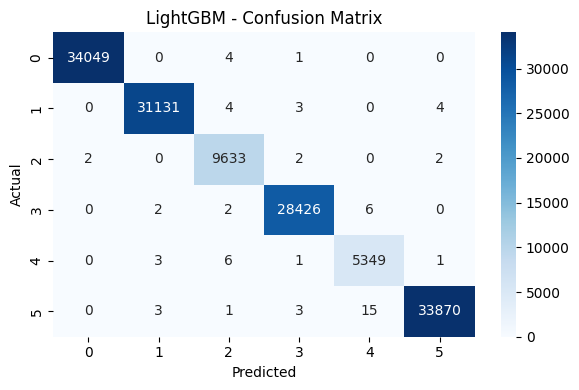

In [44]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("LightGBM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


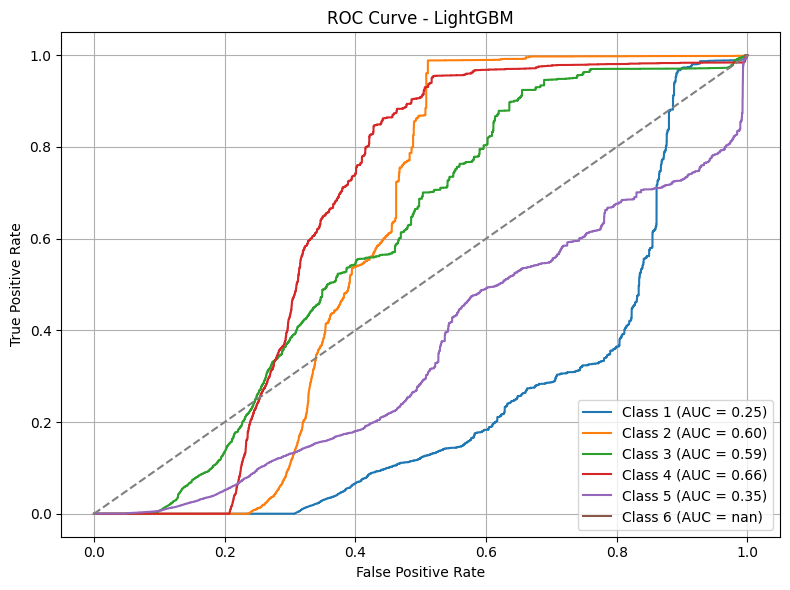

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize test labels for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_test_pred_proba = best_lgbm_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], y_test_pred_proba[:, i])
    class_label = np.unique(y)[i]
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - LightGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-47-98f7048671fa>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='viridis')


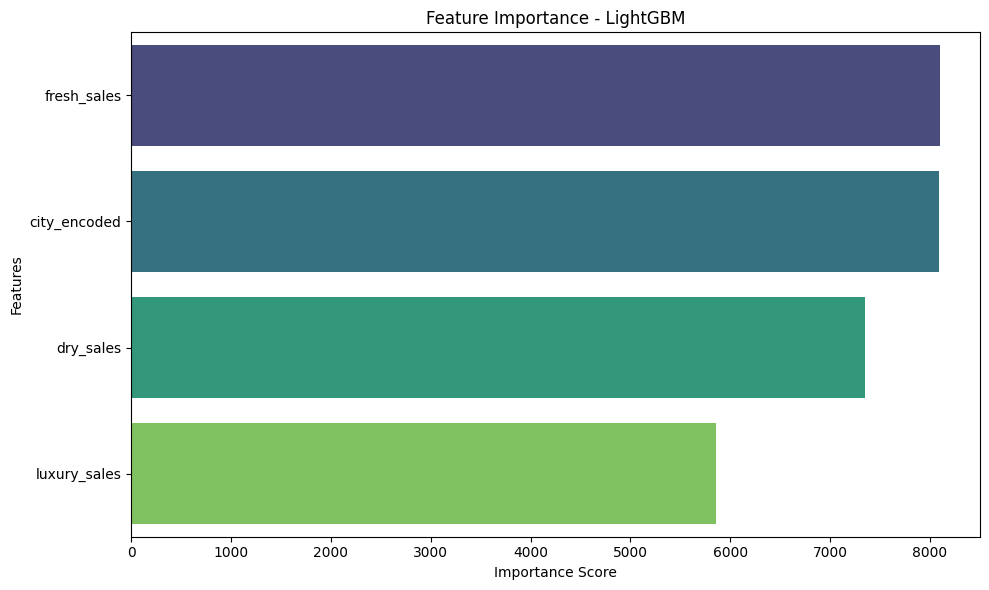

In [47]:
# Feature Importance
importances = best_lgbm_model.feature_importances_
features = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(X.shape[1])]
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(features)[indices], palette='viridis')
plt.title('Feature Importance - LightGBM')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# KNN (Train Accuracy: 1.0000, Test Accuracy: 0.9988)

In [48]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [50]:
import pandas as pd
import polars as pl

# First convert NumPy arrays to pandas DataFrames
if not isinstance(X_train, (pd.DataFrame, pl.DataFrame)):
    X_train = pd.DataFrame(X_train)

if not isinstance(X_test, (pd.DataFrame, pl.DataFrame)):
    X_test = pd.DataFrame(X_test)

if not isinstance(y_train, (pd.Series, pd.DataFrame, pl.DataFrame)):
    y_train = pd.Series(y_train, name="target")

if not isinstance(y_test, (pd.Series, pd.DataFrame, pl.DataFrame)):
    y_test = pd.Series(y_test, name="target")

# Then convert pandas to Polars if needed
X_train_pl = pl.from_pandas(X_train) if not isinstance(X_train, pl.DataFrame) else X_train
X_test_pl = pl.from_pandas(X_test) if not isinstance(X_test, pl.DataFrame) else X_test
y_train_pl = pl.from_pandas(y_train.to_frame()) if not isinstance(y_train, pl.DataFrame) else y_train
y_test_pl = pl.from_pandas(y_test.to_frame()) if not isinstance(y_test, pl.DataFrame) else y_test

In [51]:
# KNN model and hyperparameter tuning
print(f"\n🔹 Training KNN...\n")
knn_model = KNeighborsClassifier()
knn_param_grid = {
    "n_neighbors": [7, 9, 11, 13, 15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

knn_random_search = RandomizedSearchCV(
    knn_model, knn_param_grid,
    cv=5, scoring='f1_macro',
    n_jobs=-1, n_iter=10,
    random_state=42
)
knn_random_search.fit(X_train_np, y_train_np)

best_knn_model = knn_random_search.best_estimator_
print(f"✅ Best Parameters for KNN: {knn_random_search.best_params_}\n")


🔹 Training KNN...

✅ Best Parameters for KNN: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}



In [52]:
# Predictions
y_train_pred = best_knn_model.predict(X_train_np)
y_test_pred = best_knn_model.predict(X_test_np)

# Accuracy
train_acc = accuracy_score(y_train_np, y_train_pred)
test_acc = accuracy_score(y_test_np, y_test_pred)

print(f"🔹 KNN Accuracy:")
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")

🔹 KNN Accuracy:
   Train Accuracy: 1.0000
   Test Accuracy: 0.9988


In [53]:
# Classification report
print("\n🔹 Classification Report for KNN:")
print(classification_report(y_test_np, y_test_pred))


🔹 Classification Report for KNN:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     34054
           2       1.00      1.00      1.00     31142
           3       1.00      1.00      1.00      9639
           4       1.00      1.00      1.00     28436
           5       0.99      1.00      0.99      5360
           6       1.00      1.00      1.00     33892

    accuracy                           1.00    142523
   macro avg       1.00      1.00      1.00    142523
weighted avg       1.00      1.00      1.00    142523



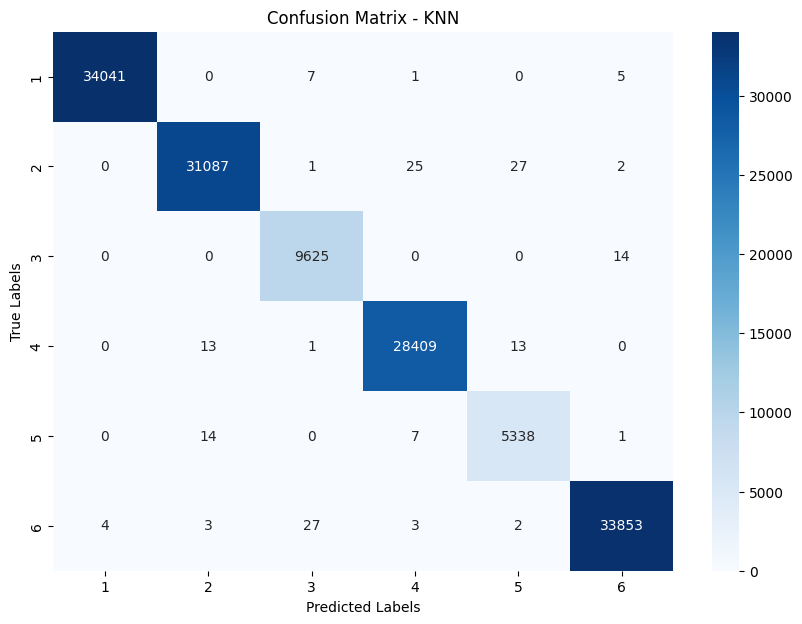

In [54]:
# Confusion Matrix
cm = confusion_matrix(y_test_np, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_train_np),
            yticklabels=np.unique(y_train_np))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - KNN")
plt.show()


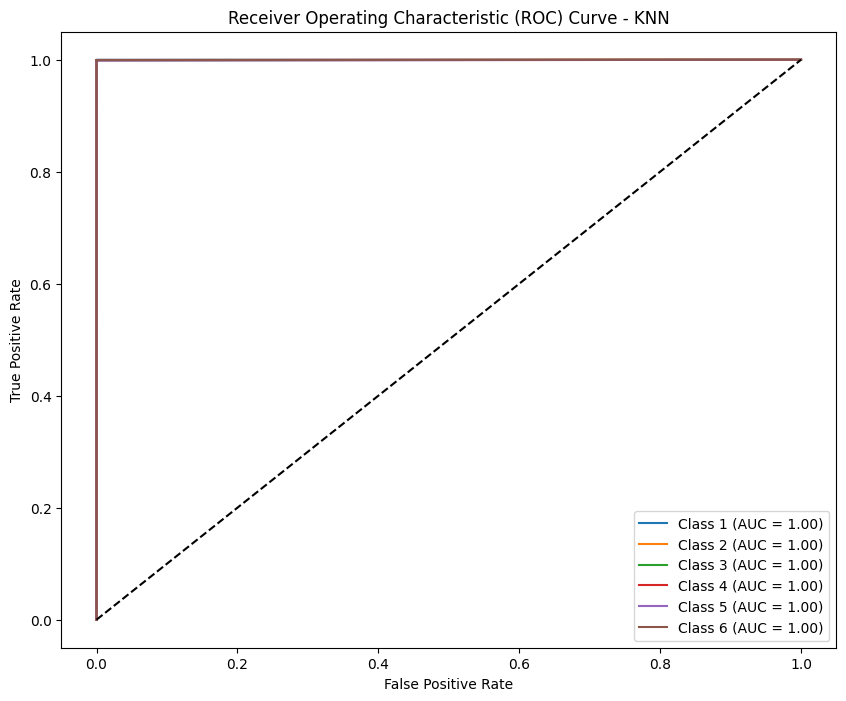

In [55]:
# ROC Curve
y_test_bin = label_binarize(y_test_np, classes=[1, 2, 3, 4, 5, 6])
y_proba_knn = best_knn_model.predict_proba(X_test_np)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_knn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend(loc="lower right")
plt.show()

# Multinomial Logistic Regression Model (Train Accuracy: 0.6858, Test Accuracy: 0.6851)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl

In [11]:
# Ensure inputs are Polars DataFrames
X_train_pl = pl.from_pandas(X_train) if not isinstance(X_train, pl.DataFrame) else X_train
X_test_pl = pl.from_pandas(X_test) if not isinstance(X_test, pl.DataFrame) else X_test
y_train_pl = pl.DataFrame({"target": y_train}) if not isinstance(y_train, pl.DataFrame) else y_train
y_test_pl = pl.DataFrame({"target": y_test}) if not isinstance(y_test, pl.DataFrame) else y_test

# Convert to NumPy arrays (float32 for performance)
X_train_np = X_train_pl.to_numpy().astype(np.float32)
X_test_np = X_test_pl.to_numpy().astype(np.float32)
y_train_np = y_train_pl["target"].to_numpy()
y_test_np = y_test_pl["target"].to_numpy()

In [12]:
log_reg_model = LogisticRegression(
    solver='saga',
    multi_class='multinomial',
    max_iter=500,
    tol=1e-3,
    random_state=42,
    n_jobs=-1,
    warm_start=True,
    class_weight='balanced'
)

param_grid = {
    'C': [0.01, 0.1, 1, 10]
}

print("\n🔹 Training Logistic Regression with optimized parameters...\n")
random_search = RandomizedSearchCV(
    estimator=log_reg_model,
    param_distributions=param_grid,
    n_iter=4,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
random_search.fit(X_train_np, y_train_np)

best_mlr_model = random_search.best_estimator_
print(f"✅ Best Parameters: {random_search.best_params_}\n")

# Final refit
best_mlr_model.set_params(max_iter=500)
best_mlr_model.fit(X_train_np, y_train_np)


🔹 Training Logistic Regression with optimized parameters...

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Best Parameters: {'C': 1}



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=1, class_weight='balanced', max_iter=500,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='saga', tol=0.001, warm_start=True)

In [13]:
y_train_pred = best_mlr_model.predict(X_train_np)
y_test_pred = best_mlr_model.predict(X_test_np)

print(f"Train Accuracy: {accuracy_score(y_train_np, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test_np, y_test_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test_np, y_test_pred))

Train Accuracy: 0.6858
Test Accuracy: 0.6851

Classification Report:
               precision    recall  f1-score   support

           1       0.57      0.46      0.51     34054
           2       0.94      0.74      0.83     31142
           3       0.49      0.71      0.58      9639
           4       0.56      0.72      0.63     28436
           5       0.38      0.65      0.48      5360
           6       0.93      0.83      0.88     33892

    accuracy                           0.69    142523
   macro avg       0.64      0.68      0.65    142523
weighted avg       0.72      0.69      0.69    142523



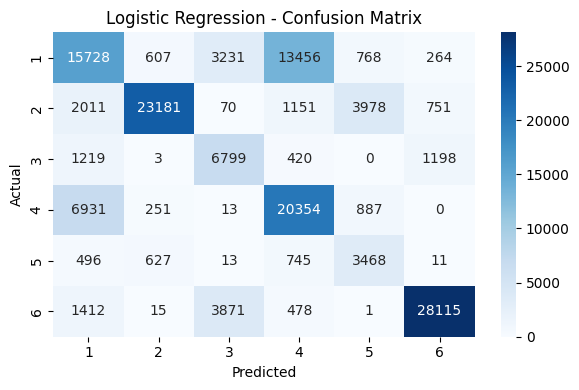

In [14]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(y_test_np, y_test_pred),
    annot=True, fmt="d", cmap="Blues",
    xticklabels=range(1, 7), yticklabels=range(1, 7)
)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

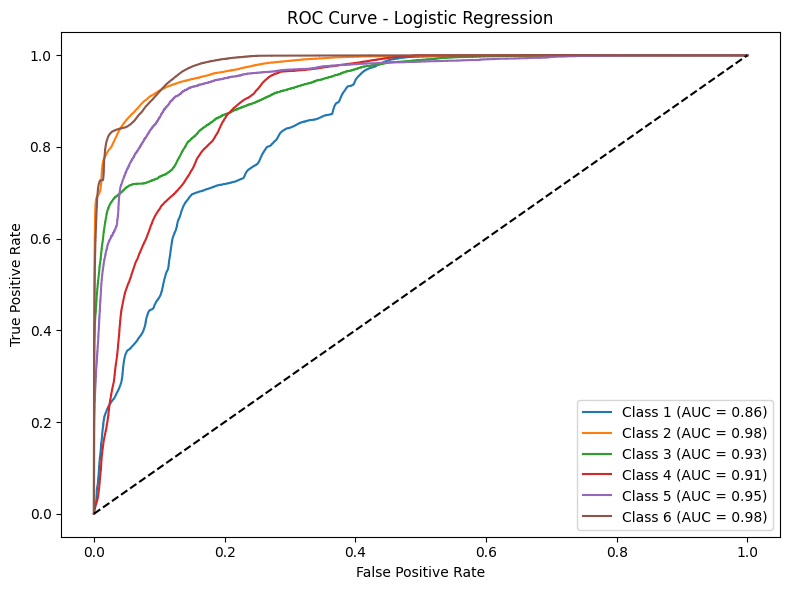

In [15]:
y_test_bin = label_binarize(y_test_np, classes=[1, 2, 3, 4, 5, 6])
y_test_pred_proba = best_mlr_model.predict_proba(X_test_np)

plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_proba[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_test_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


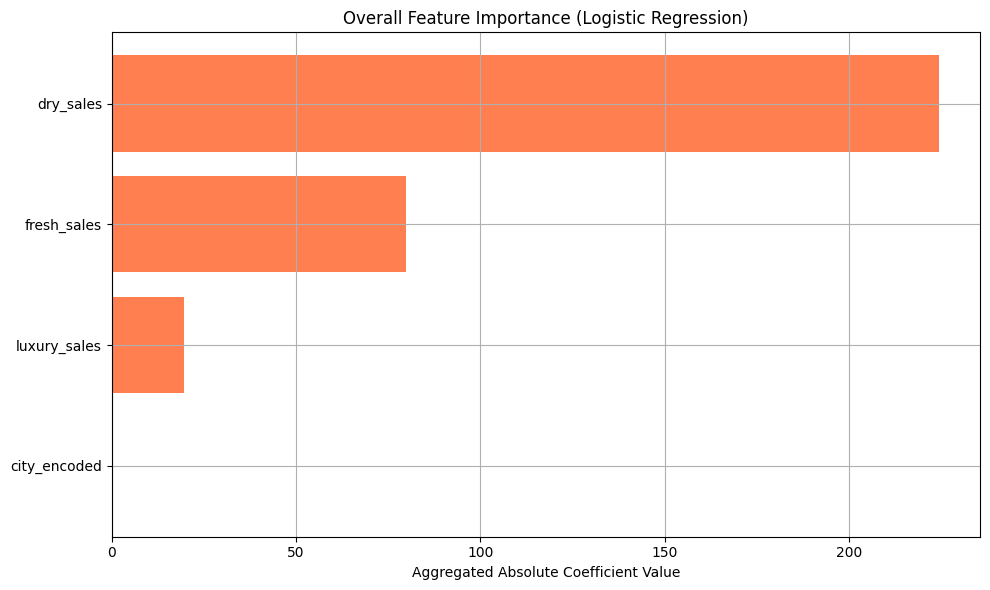

In [16]:
feature_names = X_train.columns if hasattr(X_train, "columns") else [f'Feature {i}' for i in range(X_train_np.shape[1])]
importance_scores = np.sum(np.abs(best_mlr_model.coef_), axis=0)

importance_df = pl.DataFrame({
    "Feature": feature_names,
    "Importance": importance_scores
}).sort("Importance", descending=True)

top_features_df = importance_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_features_df["Feature"].to_list(), top_features_df["Importance"].to_list(), color="coral")
plt.xlabel("Aggregated Absolute Coefficient Value")
plt.title("Overall Feature Importance (Logistic Regression)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# Saving Selected Model

In [31]:
import pickle

# Save the model using pickle
model_filename = 'final_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_ebm_model, f)
    print(f"🔹 Model saved to {model_filename}")

🔹 Model saved to final_model.pkl
